# Customer Review Analysis and Product Categorization
## Using NLP and LLMs

In [3]:
# Required Libraries
# Core data processing
import pandas as pd
import numpy as np

# NLP
from transformers import pipeline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# Text processing
import re

# Machine Learning & Deep Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
import os
import joblib

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brunoaugusto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brunoaugusto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Data Loading 

In [4]:
def load_data(file_path: str) -> pd.DataFrame:
    """
    Load data from CSV file with proper error handling
    
    Args:
        file_path: Path to the CSV file
        
    Returns:
        pd.DataFrame: Loaded dataframe
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded {file_path}")
        return df
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None


In [49]:
# File paths
file_paths = {
    'main': '1429_1.csv',
    'may19': 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv',
    'base': 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv'
}

In [51]:
# Load datasets
main_df = load_data(file_paths['main'])
may19_df = load_data(file_paths['may19'])
base_df = load_data(file_paths['base'])

/var/folders/4r/064fnvjs2j9g2l9n63gy6k0w0000gn/T/ipykernel_4243/1974511506.py:12: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Successfully loaded 1429_1.csv
Successfully loaded Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv
Successfully loaded Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv


In [53]:
main_df.head(5)


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [47]:
#helper function to get summary of the dataframe
def get_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Get summary of the dataframe
    
    Args:
        df: Dataframe to get summary of
        
    Returns:
        pd.DataFrame: Summary of the dataframe
    """
    summary = pd.DataFrame({
        'Name': df.columns,
        'dtypes': df.dtypes,
        'Missing': df.isnull().sum(),
        'Uniques': df.nunique(),
        'collums': df.columns
    })
    return summary


In [48]:
# Get summary of the main dataframe
main_summary = get_summary(main_df)
main_summary




,Name,dtypes,Missing,Uniques,collums
id,id,object,0,42,id
brand,brand,object,0,6,brand
categories,categories,object,0,41,categories
keys,keys,object,0,42,keys
manufacturer,manufacturer,object,0,2,manufacturer
reviews.dateSeen,reviews.dateSeen,object,0,3911,reviews.dateSeen
reviews.sourceURLs,reviews.sourceURLs,object,0,11929,reviews.sourceURLs


In [14]:
# Get summary of the May 2019 dataframe
may19_summary = get_summary(may19_df)
may19_summary


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
id,id,object,0,65,AVpgNzjwLJeJML43Kpxn,AVpgNzjwLJeJML43Kpxn,AVpgNzjwLJeJML43Kpxn
dateAdded,dateAdded,object,0,55,2015-10-30T08:59:32Z,2015-10-30T08:59:32Z,2015-10-30T08:59:32Z
dateUpdated,dateUpdated,object,0,52,2019-04-25T09:08:16Z,2019-04-25T09:08:16Z,2019-04-25T09:08:16Z
name,name,object,0,65,AmazonBasics AAA Performance Alkaline Batterie...,AmazonBasics AAA Performance Alkaline Batterie...,AmazonBasics AAA Performance Alkaline Batterie...
asins,asins,object,0,65,"B00QWO9P0O,B00LH3DMUO","B00QWO9P0O,B00LH3DMUO","B00QWO9P0O,B00LH3DMUO"
brand,brand,object,0,3,Amazonbasics,Amazonbasics,Amazonbasics
categories,categories,object,0,60,"AA,AAA,Health,Electronics,Health & Household,C...","AA,AAA,Health,Electronics,Health & Household,C...","AA,AAA,Health,Electronics,Health & Household,C..."
primaryCategories,primaryCategories,object,0,9,Health & Beauty,Health & Beauty,Health & Beauty
imageURLs,imageURLs,object,0,65,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...
keys,keys,object,0,65,"amazonbasics/hl002619,amazonbasicsaaaperforman...","amazonbasics/hl002619,amazonbasicsaaaperforman...","amazonbasics/hl002619,amazonbasicsaaaperforman..."


In [15]:
# Get summary of the base dataframe
base_summary = get_summary(base_df)
base_summary



,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
id,id,object,0,24,AVqVGZNvQMlgsOJE6eUY,AVqVGZNvQMlgsOJE6eUY,AVqVGZNvQMlgsOJE6eUY
dateAdded,dateAdded,object,0,20,2017-03-03T16:56:05Z,2017-03-03T16:56:05Z,2017-03-03T16:56:05Z
dateUpdated,dateUpdated,object,0,17,2018-10-25T16:36:31Z,2018-10-25T16:36:31Z,2018-10-25T16:36:31Z
name,name,object,0,23,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...","Amazon Kindle E-Reader 6"" Wifi (8th Generation...","Amazon Kindle E-Reader 6"" Wifi (8th Generation..."
asins,asins,object,0,24,B00ZV9PXP2,B00ZV9PXP2,B00ZV9PXP2
brand,brand,object,0,1,Amazon,Amazon,Amazon
categories,categories,object,0,23,"Computers,Electronics Features,Tablets,Electro...","Computers,Electronics Features,Tablets,Electro...","Computers,Electronics Features,Tablets,Electro..."
primaryCategories,primaryCategories,object,0,4,Electronics,Electronics,Electronics
imageURLs,imageURLs,object,0,24,https://pisces.bbystatic.com/image2/BestBuy_US...,https://pisces.bbystatic.com/image2/BestBuy_US...,https://pisces.bbystatic.com/image2/BestBuy_US...
keys,keys,object,0,24,allnewkindleereaderblack6glarefreetouchscreend...,allnewkindleereaderblack6glarefreetouchscreend...,allnewkindleereaderblack6glarefreetouchscreend...


# 1.1 Preprocessing - Data cleaning

In [16]:
#Helper function to get missing values and remove in the dataframe

def remove_all_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove columns with any missing values from the dataframe
    
    Args:
        df: Dataframe to remove missing values from
        
    Returns:
        pd.DataFrame: Dataframe with columns containing any missing values removed
    """
    df = df.dropna(axis=1, how='any')
    return df
    

In [28]:
# Remove columns with missing values from the main dataframe
main_df = remove_all_missing_values(main_df)



In [ ]:
#get summary of the main dataframe
main_summary = get_summary(main_df)
main_summary


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
id,id,object,0,42,AVqkIhwDv8e3D1O-lebb,AVqkIhwDv8e3D1O-lebb,AVqkIhwDv8e3D1O-lebb
brand,brand,object,0,6,Amazon,Amazon,Amazon
categories,categories,object,0,41,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","Electronics,iPad & Tablets,All Tablets,Fire Ta...","Electronics,iPad & Tablets,All Tablets,Fire Ta..."
keys,keys,object,0,42,"841667104676,amazon/53004484,amazon/b01ahb9cn2...","841667104676,amazon/53004484,amazon/b01ahb9cn2...","841667104676,amazon/53004484,amazon/b01ahb9cn2..."
manufacturer,manufacturer,object,0,2,Amazon,Amazon,Amazon
reviews.dateSeen,reviews.dateSeen,object,0,3911,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z","2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z","2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z"
reviews.sourceURLs,reviews.sourceURLs,object,0,11929,http://reviews.bestbuy.com/3545/5620406/review...,http://reviews.bestbuy.com/3545/5620406/review...,http://reviews.bestbuy.com/3545/5620406/review...


In [27]:
# Remove columns with missing values from the May 2019 dataframe
may19_df = remove_all_missing_values(may19_df)


In [22]:
# Get summary of the May 2019 dataframe
may19_summary = get_summary(may19_df)
may19_summary

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
id,id,object,0,65,AVpgNzjwLJeJML43Kpxn,AVpgNzjwLJeJML43Kpxn,AVpgNzjwLJeJML43Kpxn
dateAdded,dateAdded,object,0,55,2015-10-30T08:59:32Z,2015-10-30T08:59:32Z,2015-10-30T08:59:32Z
dateUpdated,dateUpdated,object,0,52,2019-04-25T09:08:16Z,2019-04-25T09:08:16Z,2019-04-25T09:08:16Z
name,name,object,0,65,AmazonBasics AAA Performance Alkaline Batterie...,AmazonBasics AAA Performance Alkaline Batterie...,AmazonBasics AAA Performance Alkaline Batterie...
asins,asins,object,0,65,"B00QWO9P0O,B00LH3DMUO","B00QWO9P0O,B00LH3DMUO","B00QWO9P0O,B00LH3DMUO"
brand,brand,object,0,3,Amazonbasics,Amazonbasics,Amazonbasics
categories,categories,object,0,60,"AA,AAA,Health,Electronics,Health & Household,C...","AA,AAA,Health,Electronics,Health & Household,C...","AA,AAA,Health,Electronics,Health & Household,C..."
primaryCategories,primaryCategories,object,0,9,Health & Beauty,Health & Beauty,Health & Beauty
imageURLs,imageURLs,object,0,65,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...
keys,keys,object,0,65,"amazonbasics/hl002619,amazonbasicsaaaperforman...","amazonbasics/hl002619,amazonbasicsaaaperforman...","amazonbasics/hl002619,amazonbasicsaaaperforman..."


In [25]:
# Remove columns with missing values from the base dataframe
base_df = remove_all_missing_values(base_df)


In [29]:
# Get summary of the base dataframe
base_summary = get_summary(base_df)
base_summary


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
id,id,object,0,24,AVqVGZNvQMlgsOJE6eUY,AVqVGZNvQMlgsOJE6eUY,AVqVGZNvQMlgsOJE6eUY
dateAdded,dateAdded,object,0,20,2017-03-03T16:56:05Z,2017-03-03T16:56:05Z,2017-03-03T16:56:05Z
dateUpdated,dateUpdated,object,0,17,2018-10-25T16:36:31Z,2018-10-25T16:36:31Z,2018-10-25T16:36:31Z
name,name,object,0,23,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...","Amazon Kindle E-Reader 6"" Wifi (8th Generation...","Amazon Kindle E-Reader 6"" Wifi (8th Generation..."
asins,asins,object,0,24,B00ZV9PXP2,B00ZV9PXP2,B00ZV9PXP2
brand,brand,object,0,1,Amazon,Amazon,Amazon
categories,categories,object,0,23,"Computers,Electronics Features,Tablets,Electro...","Computers,Electronics Features,Tablets,Electro...","Computers,Electronics Features,Tablets,Electro..."
primaryCategories,primaryCategories,object,0,4,Electronics,Electronics,Electronics
imageURLs,imageURLs,object,0,24,https://pisces.bbystatic.com/image2/BestBuy_US...,https://pisces.bbystatic.com/image2/BestBuy_US...,https://pisces.bbystatic.com/image2/BestBuy_US...
keys,keys,object,0,24,allnewkindleereaderblack6glarefreetouchscreend...,allnewkindleereaderblack6glarefreetouchscreend...,allnewkindleereaderblack6glarefreetouchscreend...


In [41]:
# Function to plot the distribution of the reviews ratings
def plot_rating_distribution(df: pd.DataFrame, title: str) -> None:
    """
    Plot distribution of the review ratings
    
    Args:
        df: Dataframe to plot the distribution of review ratings
        title: Title of the plot
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='reviews.rating' if 'reviews.rating' in df.columns else 'rating')
    plt.title(title)
    plt.xlabel('Review Ratings')
    plt.ylabel('Count')
    plt.show()


In [42]:
# Plot distribution of the review ratings for the main dataframe
plot_rating_distribution(main_df, 'Main Dataset Review Ratings Distribution')

ValueError: Could not interpret value `rating` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

# 1.2 Exploratory data Analysis

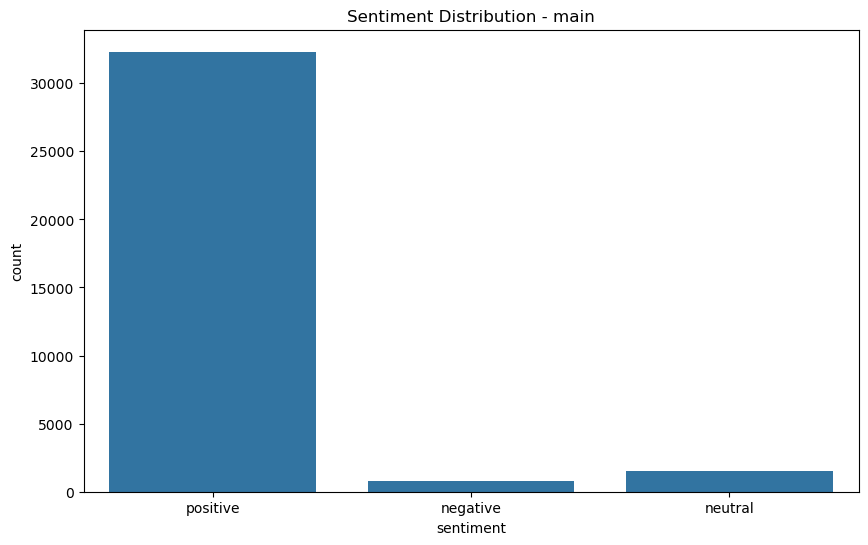

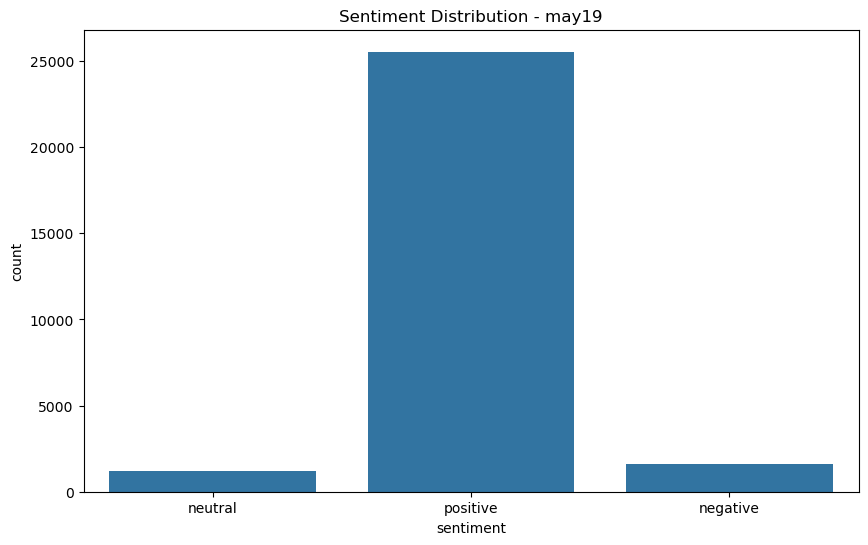

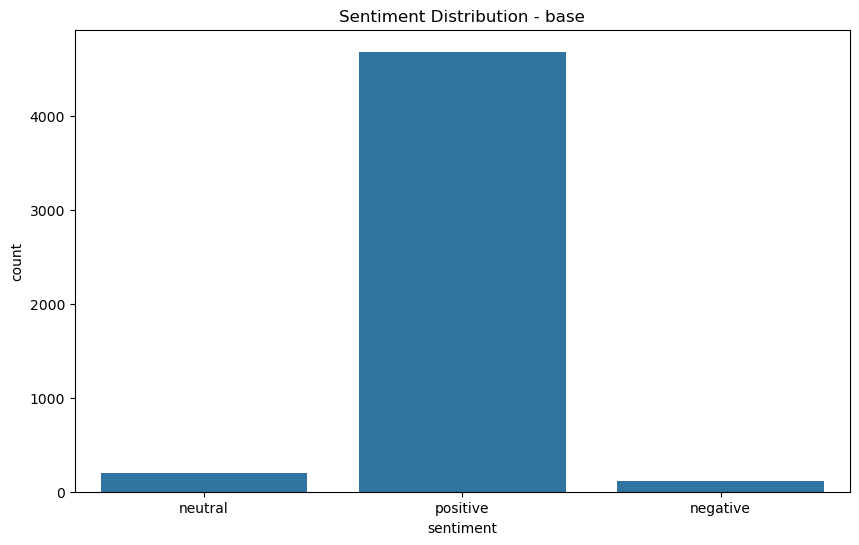

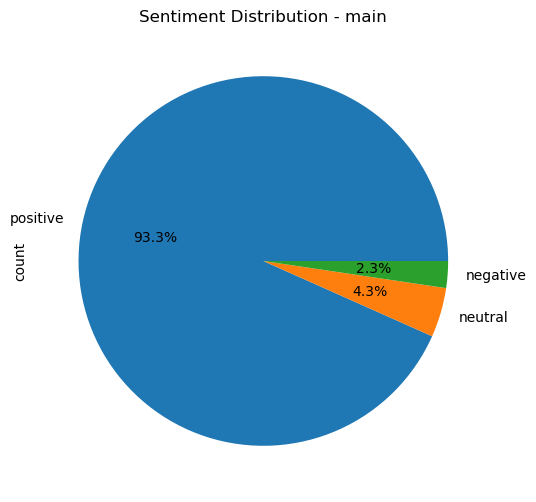

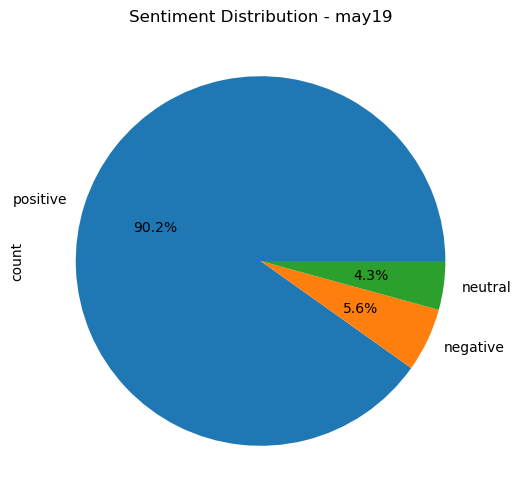

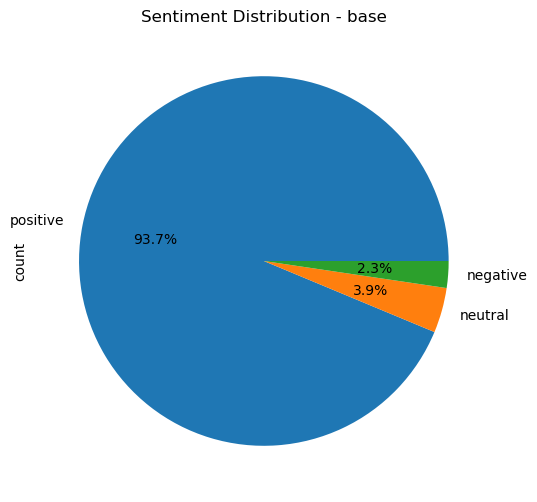

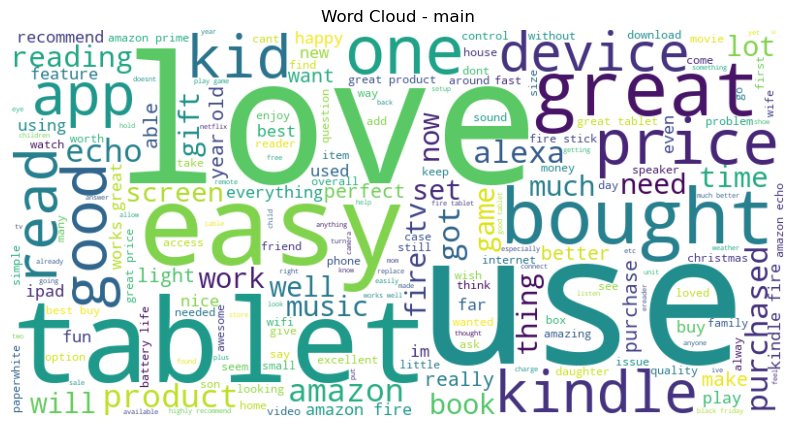

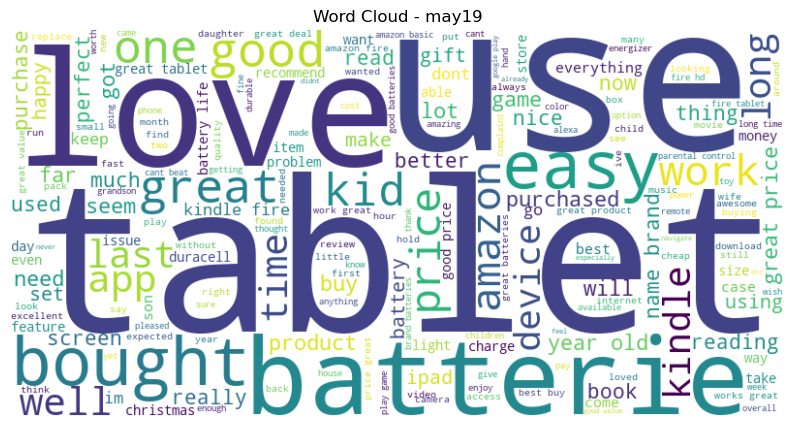

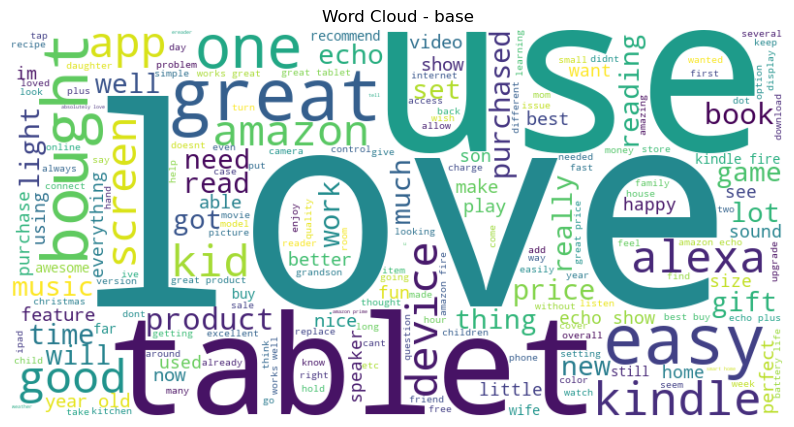

In [8]:
#Exploratory Analysis
def plot_sentiment_distribution(df, name):
    """Plot sentiment distribution"""
    plt.figure(figsize=(10,6))
    sns.countplot(data=df, x='sentiment')
    plt.title(f'Sentiment Distribution - {name}')
    plt.show()

# Plot sentiment distribution for each dataset
for name, df in datasets_clean.items():
    plot_sentiment_distribution(df, name)
    
# Visualize class distribution pie chart for each dataset
def plot_class_distribution(df, name):
    plt.figure(figsize=(6, 6))
    df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title(f'Sentiment Distribution - {name}')
    plt.show()

for name, df in datasets_clean.items():
    plot_class_distribution(df, name)

# Generate word cloud for each dataset
def plot_word_cloud(df, name):
    """Generate and plot word cloud"""
    text = ' '.join(df['clean_text'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {name}')
    plt.show()

for name, df in datasets_clean.items():
    plot_word_cloud(df, name)


# 1.2 Preprocessing for Modeling

In [9]:
# Encode sentiment labels
def encode_sentiment(df):
    """Encode sentiment labels"""
    df['sentiment_encoded'] = df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})
    return df 

# Encode sentiment labels
for name, df in datasets_clean.items():
    df_encoded = encode_sentiment(df)
    datasets_clean[name] = df_encoded
    print(f"\n{name} dataset shape after encoding: {df_encoded.shape}")
    print("\nHead:")
    print(df_encoded.head(2))
    print("\nValue counts:")
    print(df_encoded['sentiment_encoded'].value_counts())  




main dataset shape after encoding: (34626, 5)

Head:
                                        reviews.text  reviews.rating  \
0  This product so far has not disappointed. My c...             5.0   
1  great for beginner or experienced person. Boug...             5.0   

                                          clean_text sentiment  \
0  this product so far has not disappointed my ch...  positive   
1  great for beginner or experienced person bough...  positive   

   sentiment_encoded  
0                  2  
1                  2  

Value counts:
sentiment_encoded
2    32315
1     1499
0      812
Name: count, dtype: int64

may19 dataset shape after encoding: (28332, 5)

Head:
                                        reviews.text  reviews.rating  \
0  I order 3 of them and one of the item is bad q...               3   
1  Bulk is always the less expensive way to go fo...               4   

                                          clean_text sentiment  \
0  i order 3 of them and one of

In [12]:
#Vectorize text TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_text(df, max_features=5000):
    """Vectorize text using TF-IDF"""
    # Replace nan values with an empty string
    df['clean_text'] = df['clean_text'].fillna('')
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
    X = vectorizer.fit_transform(df['clean_text'])
    return X, vectorizer

# Vectorize text
Xs = {}
vectorizers = {}
for name, df in datasets_clean.items():
    X, vectorizer = vectorize_text(df)
    Xs[name] = X
    vectorizers[name] = vectorizer
    print(f"\n{name} dataset vectorized text shape: {X.shape}")
    print("\nSample features:")





main dataset vectorized text shape: (34626, 5000)

Sample features:

may19 dataset vectorized text shape: (28332, 5000)

Sample features:

base dataset vectorized text shape: (5000, 5000)

Sample features:


## 2. Data splitting


main dataset splits:
Training set shape: (27700, 5000), (27700,)
Validation set shape: (3463, 5000), (3463,)
Test set shape: (3463, 5000), (3463,)

may19 dataset splits:
Training set shape: (22665, 5000), (22665,)
Validation set shape: (2833, 5000), (2833,)
Test set shape: (2834, 5000), (2834,)

base dataset splits:
Training set shape: (4000, 5000), (4000,)
Validation set shape: (500, 5000), (500,)
Test set shape: (500, 5000), (500,)


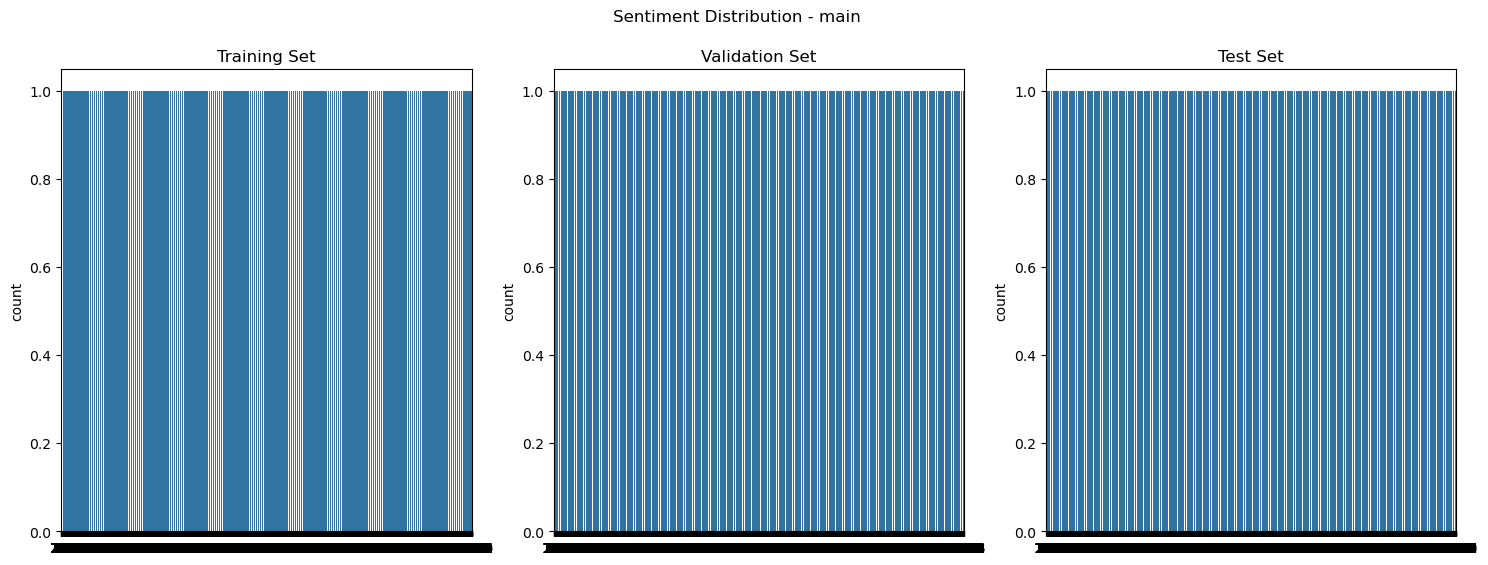

KeyboardInterrupt: 

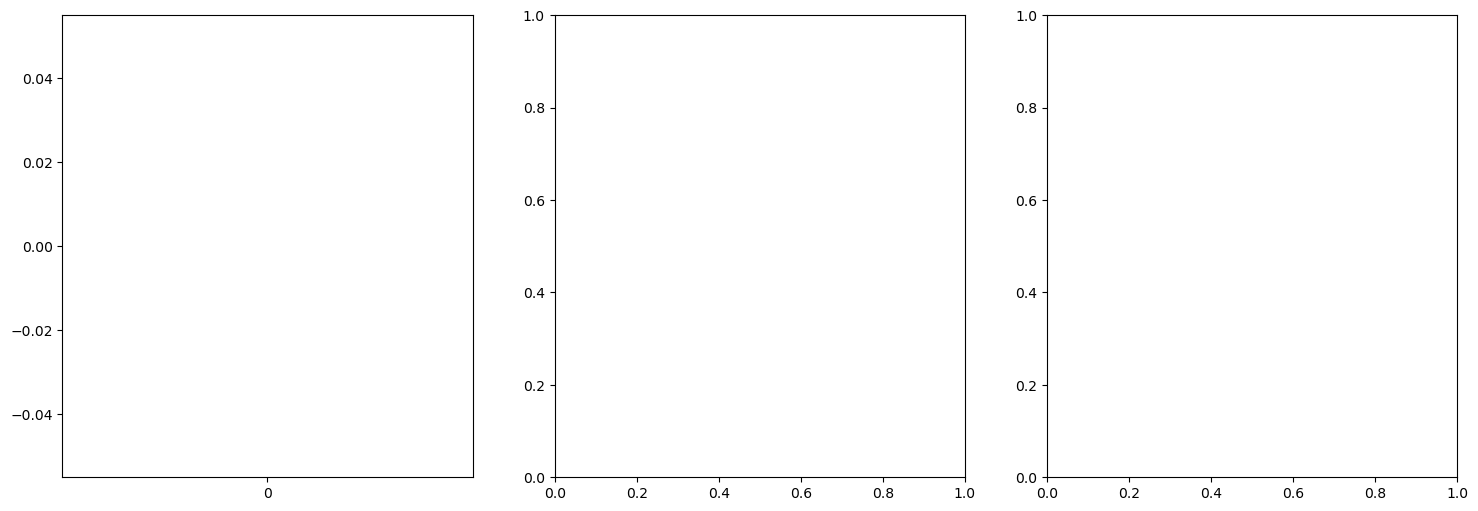

In [ ]:
# splitting the clean datasets into training(60%), validation(20%) and test set (20%)

def split_data(X, y):
    """Split data into training, validation, and test sets"""
    # Split data into training and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Split temporary data into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Split datasets
dataset_splits = {}
for name, X in Xs.items():
    y = datasets_clean[name]['sentiment_encoded']
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
    dataset_splits[name] = {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test
    }
    print(f"\n{name} dataset splits:")
    print(f"Training set shape: {X_train.shape}, {y_train.shape}")
    print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
    print(f"Test set shape: {X_test.shape}, {y_test.shape}")




# 3. Sentiment Analysis using LLM - BERT Model

In [1]:
#Classification Model call 
# Initialize the pipeline
classifier = pipeline(
    'sentiment-analysis',
    model='distilbert-base-uncased-finetuned-sst-2-english',
    device=-1,
    max_length=512,
    truncation=True
)

# Test the pipeline
text = "Hugging Face makes NLP incredibly easy!"
result = classifier(text)
print(result)


NameError: name 'pipeline' is not defined

In [ ]:
# Evaluate the model from the pipeline on the test set
def evaluate_model(classifier, X_test, y_test, name):
    """Evaluate the model on the test set"""
    y_pred = []
    for text in X_test:
        result = classifier(text)
        label = result[0]['label']
        if label == 'NEGATIVE':
            y_pred.append('negative')
        elif label == 'NEUTRAL':
            y_pred.append('neutral')
        else:
            y_pred.append('positive')
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    return accuracy, report, confusion

# Evaluate the model on the test set
for name, splits in dataset_splits.items():
    X_test_indices = splits['X_test'].indices
    X_test_texts = datasets_clean[name].iloc[X_test_indices]['clean_text'].tolist()
    y_test = splits['y_test'].tolist()
    accuracy, report, confusion = evaluate_model(classifier, X_test_texts, y_test, name)
    print(f"\n{name} dataset accuracy: {accuracy}")
    print(f"\n{name} dataset classification report:\n{report}")
    print(f"\n{name} dataset confusion matrix:\n{confusion}")
